In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import copy, json, ast, csv
import missingno as msno

from collections import Counter
from scipy import stats
from scipy.stats import skew
from math import sqrt
from numpy import mean, var
from sklearn import preprocessing


In [2]:
df = pd.read_csv('dataset_concatenado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57386 entries, 0 to 57385
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                57386 non-null  int64  
 1   genres                57386 non-null  object 
 2   id                    57386 non-null  int64  
 3   original_language     57371 non-null  object 
 4   overview              55930 non-null  object 
 5   popularity            57386 non-null  float64
 6   production_countries  57386 non-null  object 
 7   release_date          57386 non-null  object 
 8   revenue               57386 non-null  float64
 9   runtime               57021 non-null  float64
 10  spoken_languages      57386 non-null  object 
 11  status                57283 non-null  object 
 12  tagline               24209 non-null  object 
 13  title                 57386 non-null  object 
 14  vote_average          57386 non-null  float64
 15  vote_count         

In [3]:
#analizamos los valores nulos
df.isnull().mean().sort_values(ascending=False)

character               0.790594
name.1                  0.769526
job                     0.769526
name                    0.769526
cast_id                 0.769526
credit_id               0.769526
department              0.769526
tagline                 0.578138
overview                0.025372
runtime                 0.006360
status                  0.001795
original_language       0.000261
production_countries    0.000000
genres                  0.000000
id                      0.000000
budget                  0.000000
popularity              0.000000
revenue                 0.000000
release_date            0.000000
release_year            0.000000
title                   0.000000
spoken_languages        0.000000
vote_count              0.000000
vote_average            0.000000
return                  0.000000
dtype: float64

<Axes: >

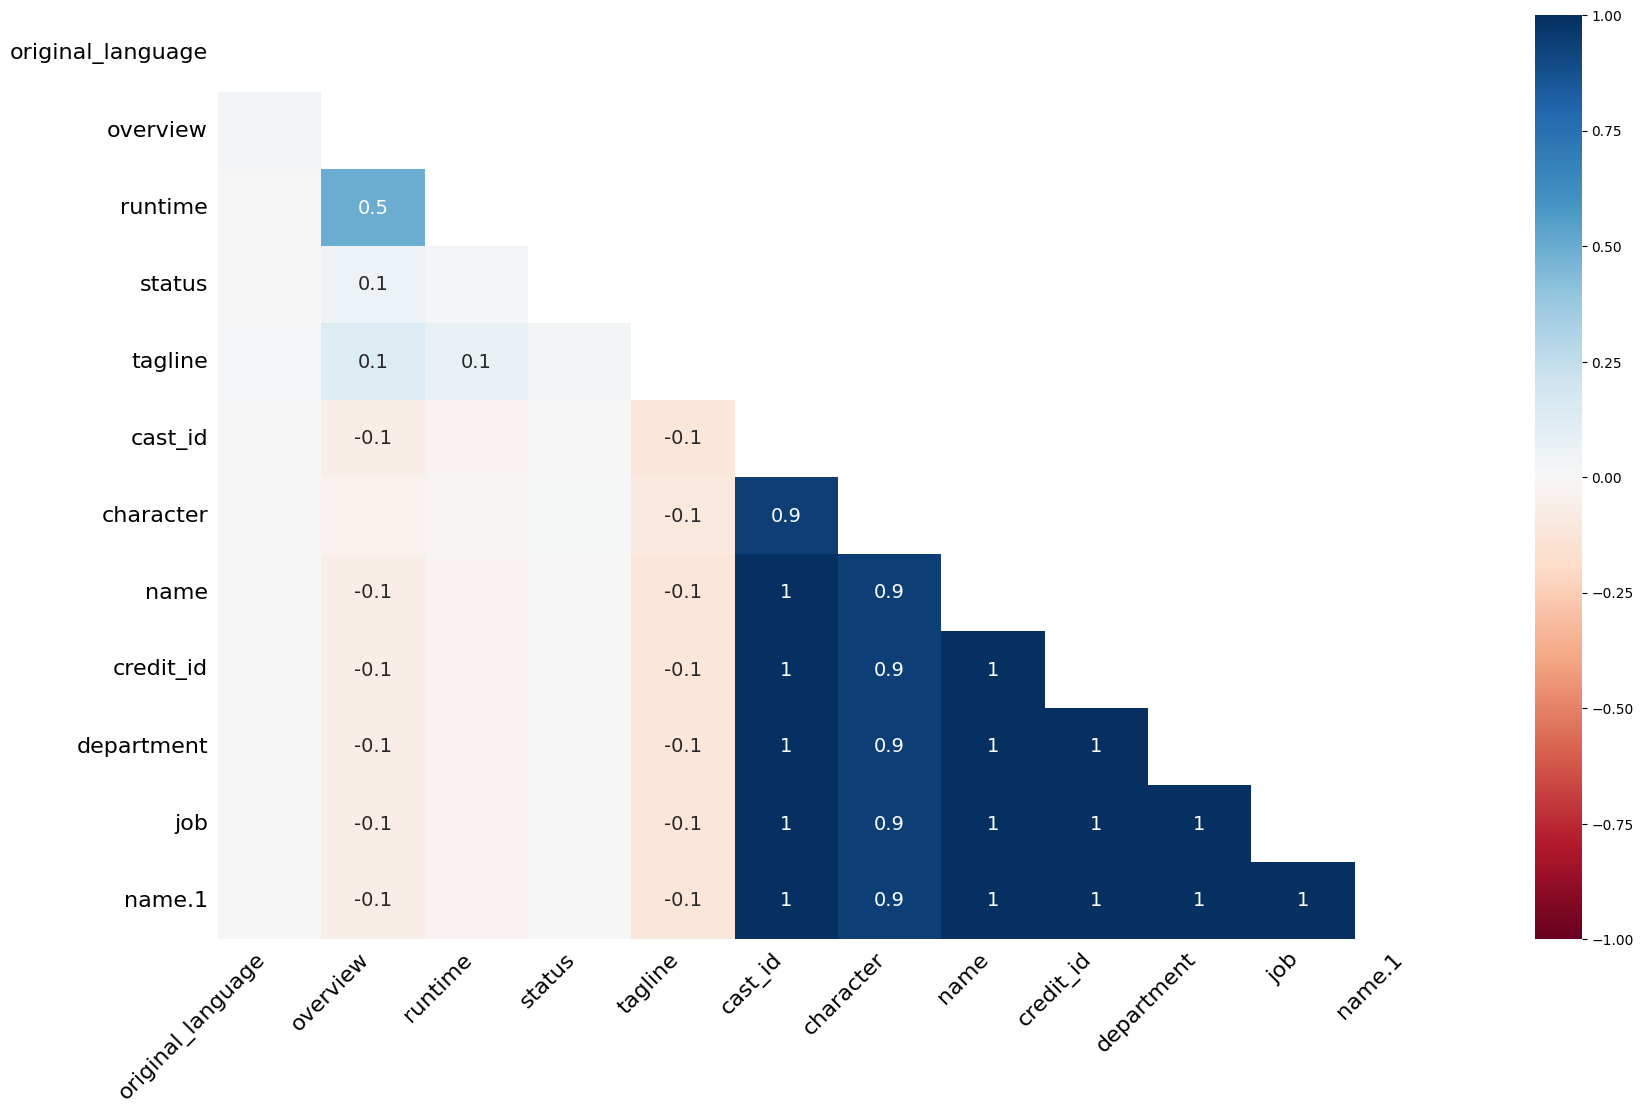

In [4]:
#muestra la correlación de la nulidad entre columnas
msno.heatmap(df)

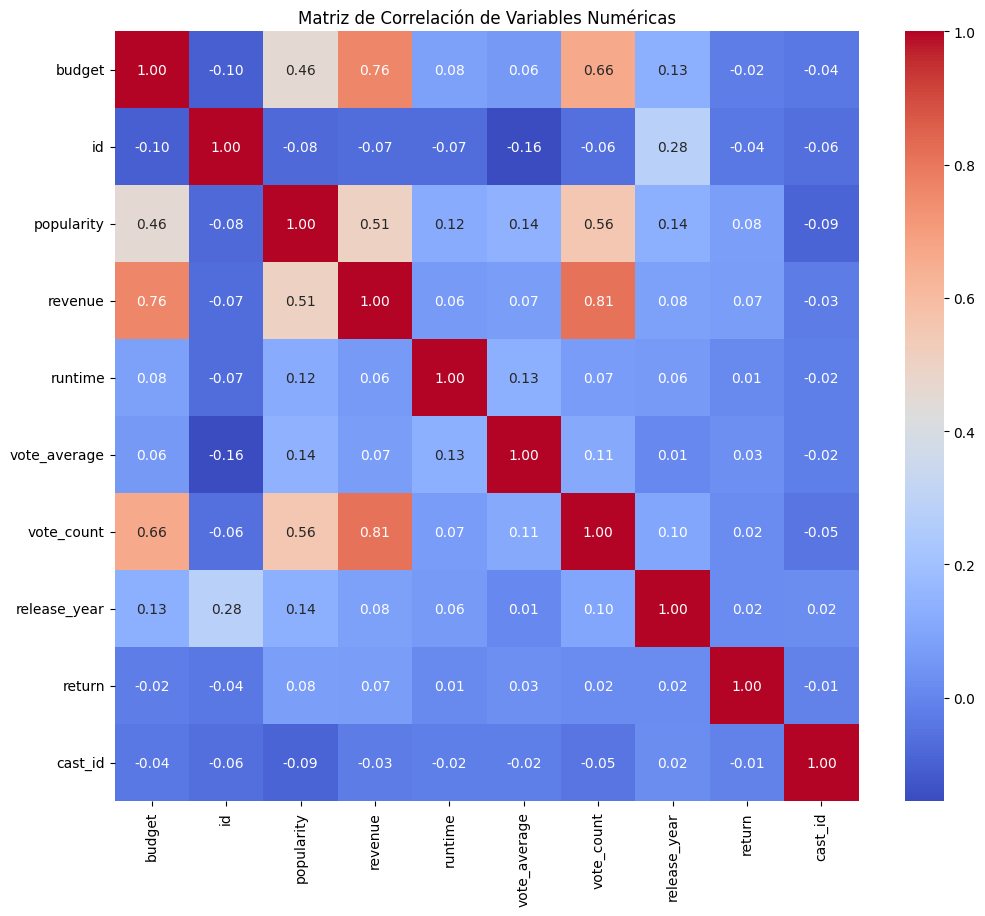

In [5]:
#analizamos la relación entre variables
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

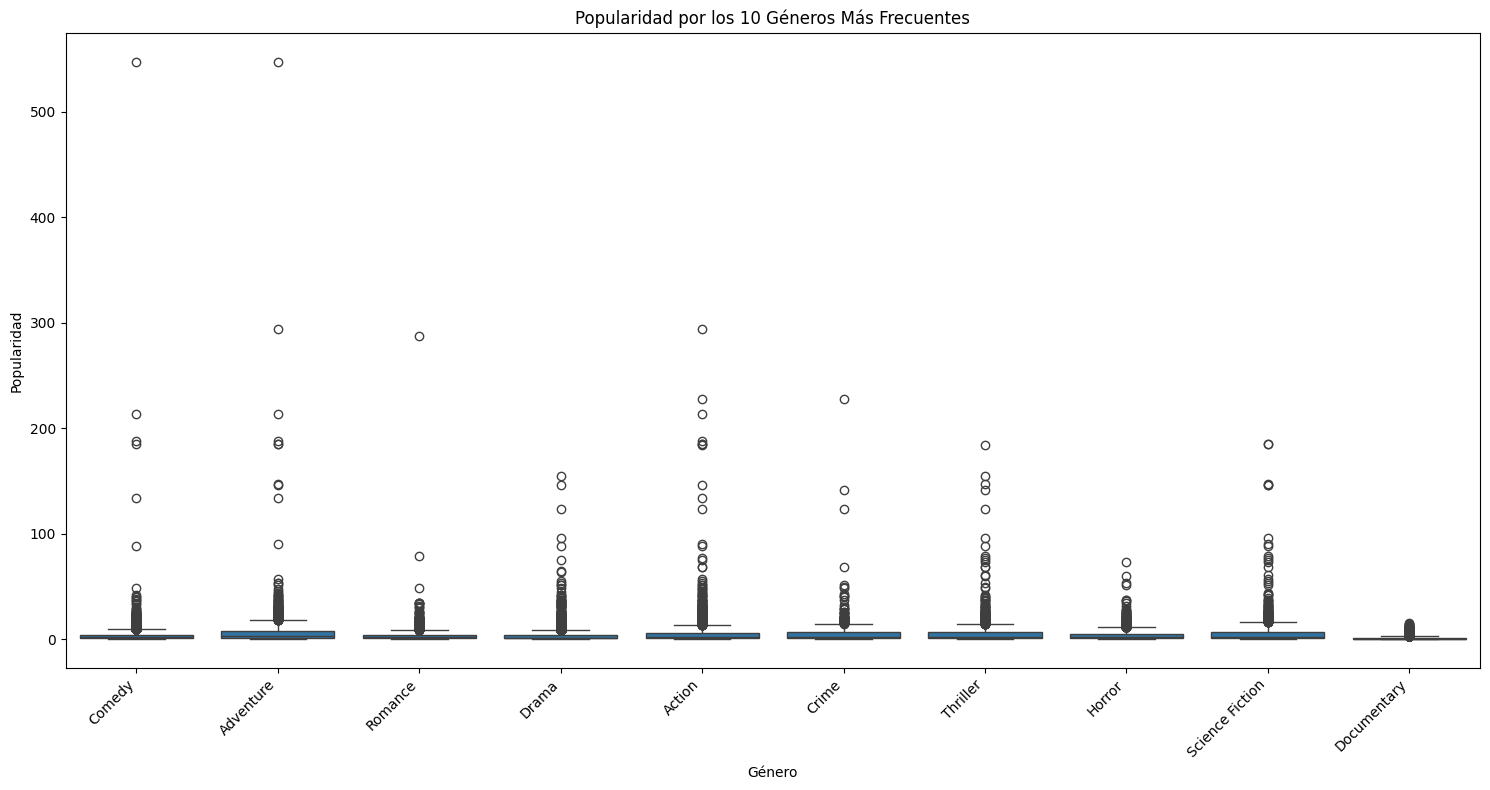

In [6]:
#Función para extraer todos los géneros de la lista
def get_all_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        if isinstance(genres_list, list):
            return [genre['name'] for genre in genres_list]
    except (ValueError, TypeError):
        return []

#aplicamos la función para obtener una lista de todos los géneros por película
df['all_genres'] = df['genres'].apply(get_all_genres)

#creamos una lista plana de todos los géneros
all_genres_list = [genre for sublist in df['all_genres'] for genre in sublist]

#contamos la frecuencia de cada género
genre_counts = Counter(all_genres_list)

#obtenemos los N géneros más comunes (ajusta N según sea necesario)
top_n_genres = [genre for genre, count in genre_counts.most_common(10)]

#filtramos el DataFrame para incluir solo películas con estos géneros principales
df_filtered = df[df['all_genres'].apply(lambda x: any(genre in x for genre in top_n_genres))]

#explotamos la columna de géneros para tener una fila por género
df_exploded = df_filtered.explode('all_genres')
df_exploded = df_exploded[df_exploded['all_genres'].isin(top_n_genres)]

plt.figure(figsize=(15, 8))
sns.boxplot(x='all_genres', y='popularity', data=df_exploded)
plt.xticks(rotation=45, ha='right')
plt.title(f'Popularidad por los {len(top_n_genres)} Géneros Más Frecuentes')
plt.xlabel('Género')
plt.ylabel('Popularidad')
plt.tight_layout()
plt.show()

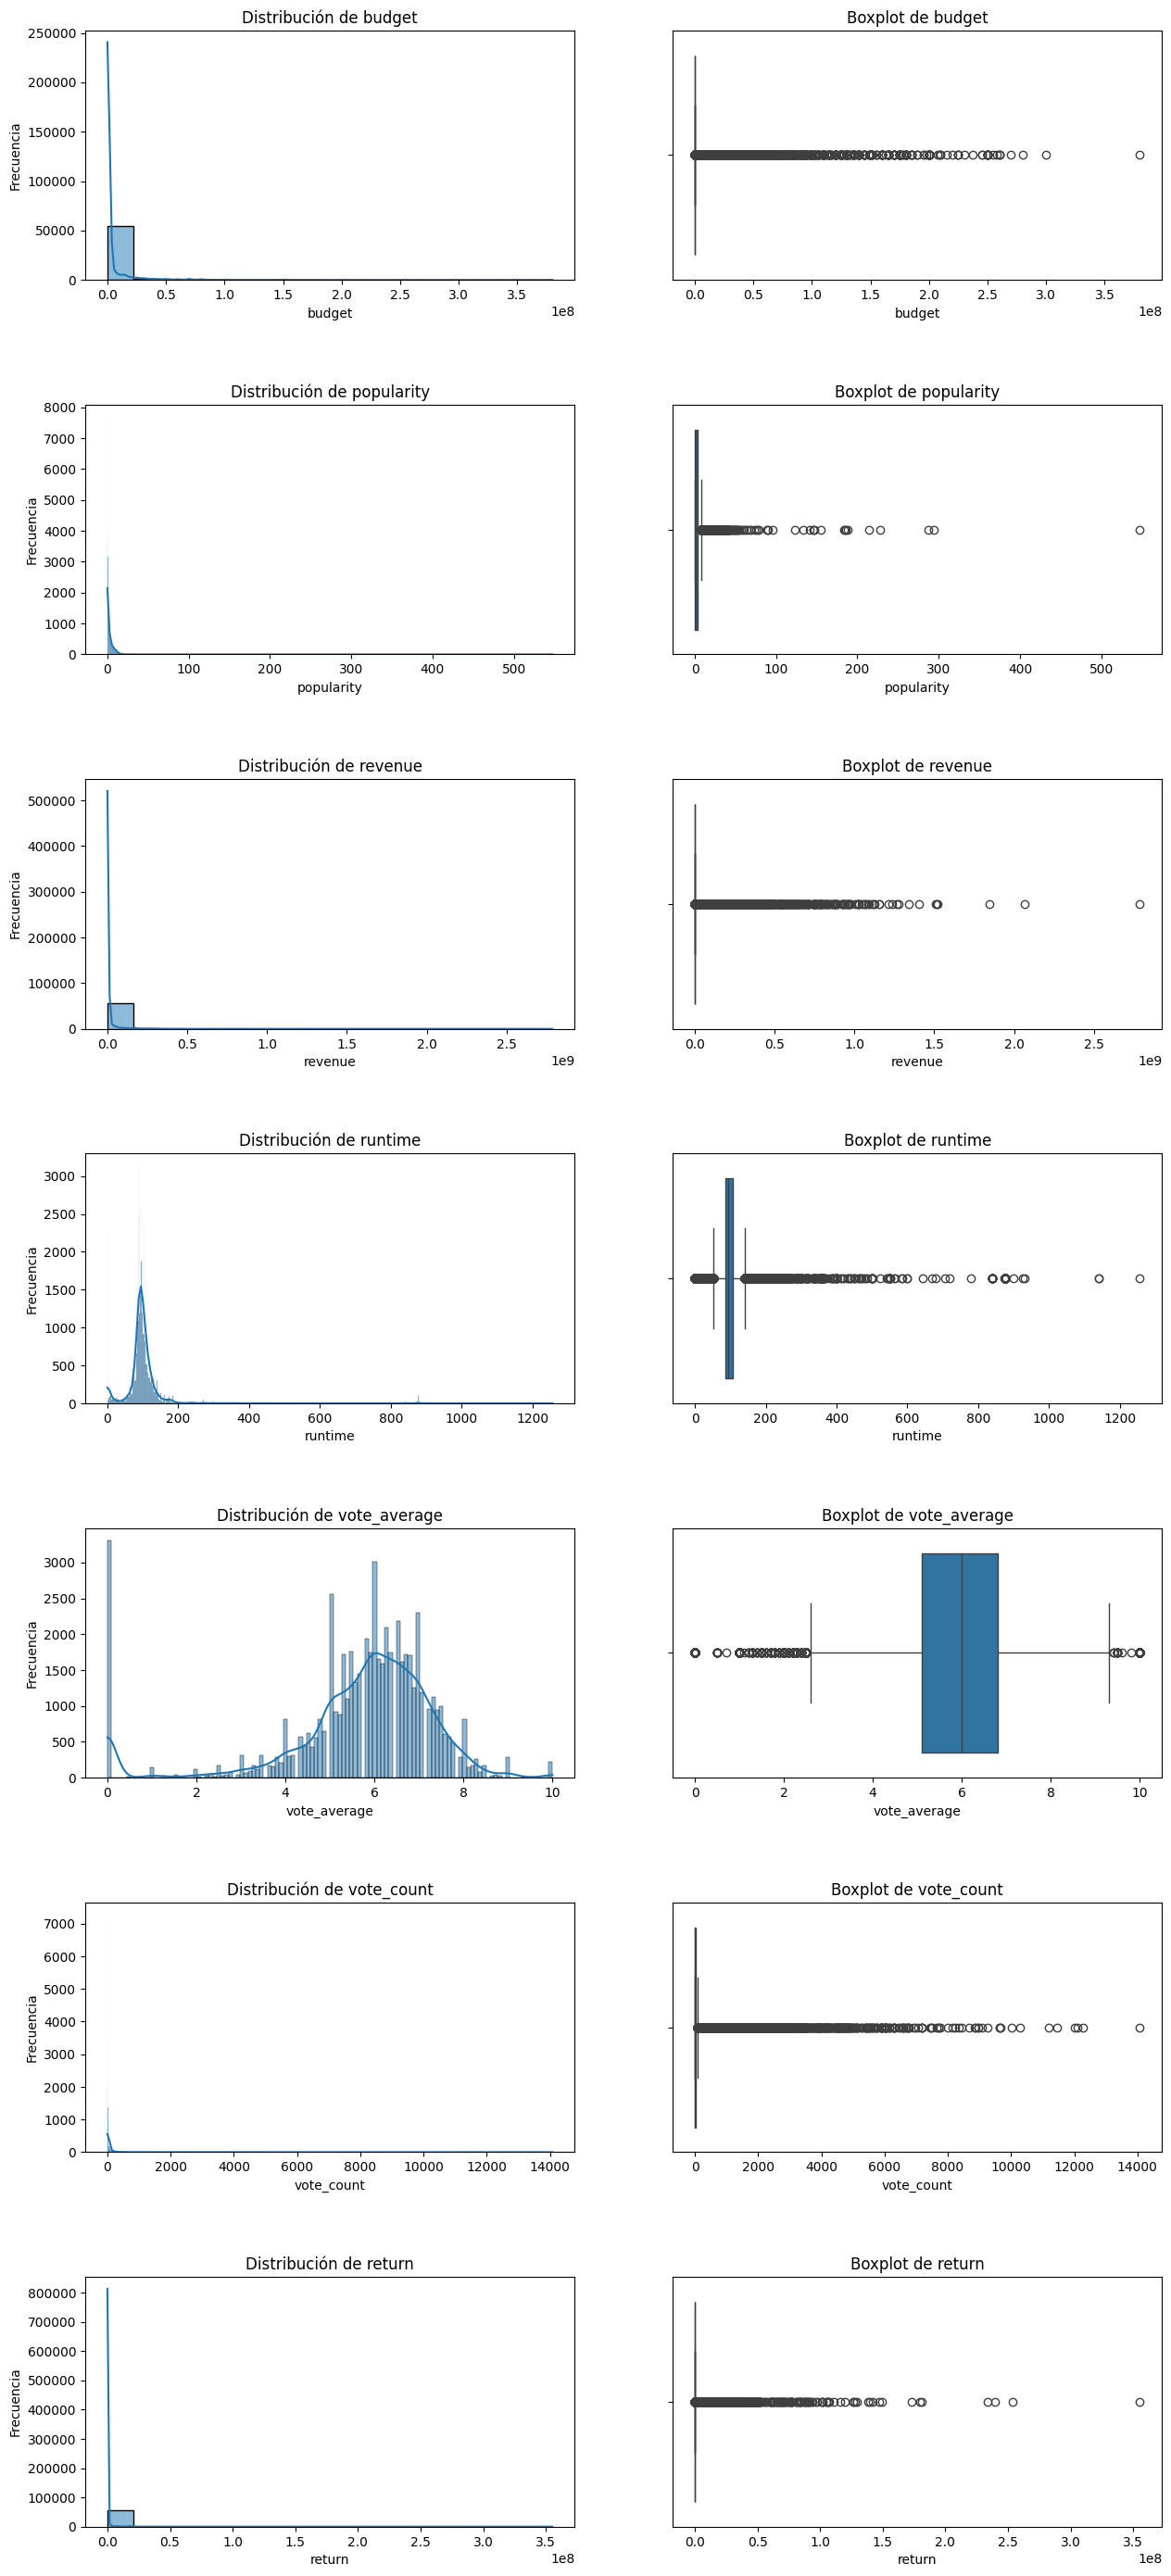


Skewness y Kurtosis:
budget: Skewness = 7.29, Kurtosis = 71.93
popularity: Skewness = 30.12, Kurtosis = 2159.00
revenue: Skewness = 13.38, Kurtosis = 286.76
runtime: Skewness = 7.97, Kurtosis = 115.95
vote_average: Skewness = -1.57, Kurtosis = 2.94
vote_count: Skewness = 11.62, Kurtosis = 188.15
return: Skewness = 24.01, Kurtosis = 934.93


In [7]:
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'return']

#creamos una figura con subplots para cada variable
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(15, 5 * len(numeric_cols)))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(numeric_cols):
    # Histograma
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frecuencia')

    # Boxplot
    sns.boxplot(x=df[col].dropna(), ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col}')
    axes[i, 1].set_xlabel(col)

plt.show()

#calculamos Skewness y Kurtosis
print("\nSkewness y Kurtosis:")
for col in numeric_cols:
    skewness = df[col].skew()
    kurtosis = df[col].kurt()
    print(f"{col}: Skewness = {skewness:.2f}, Kurtosis = {kurtosis:.2f}")

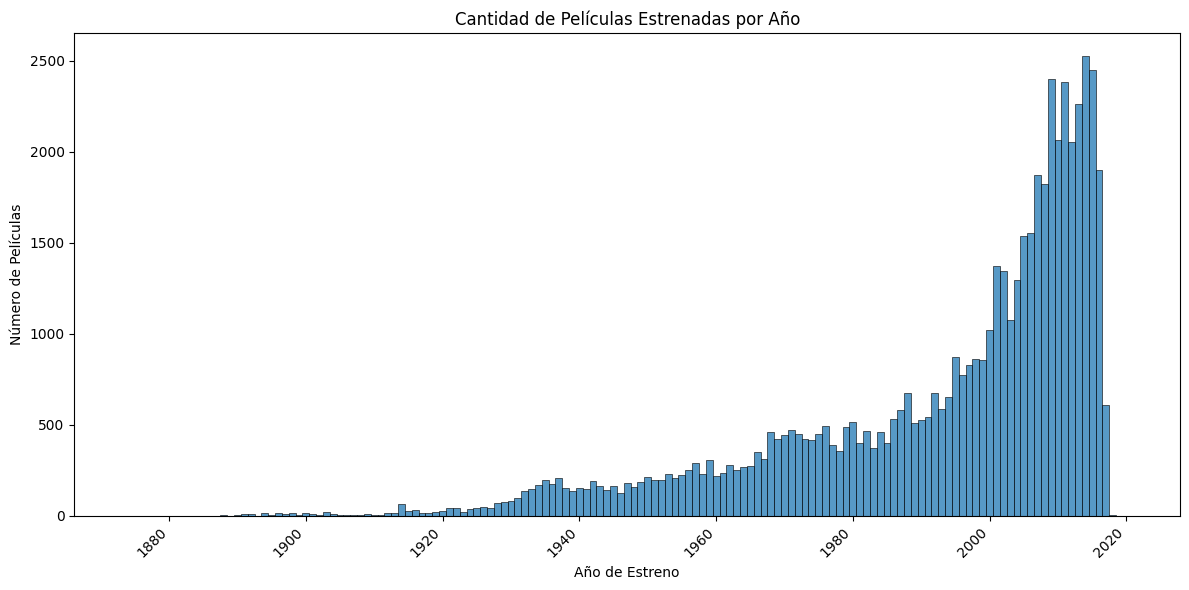

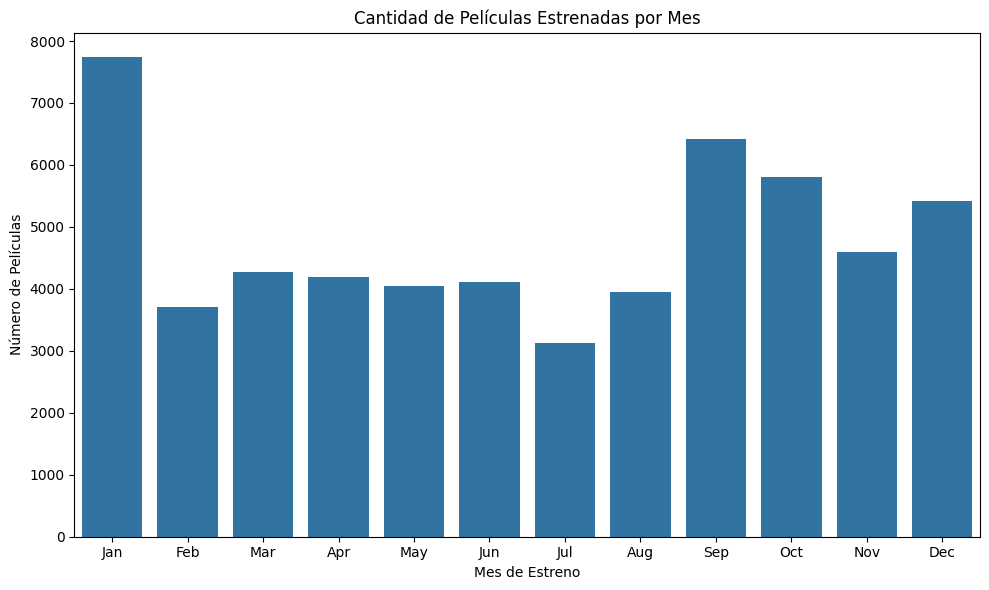

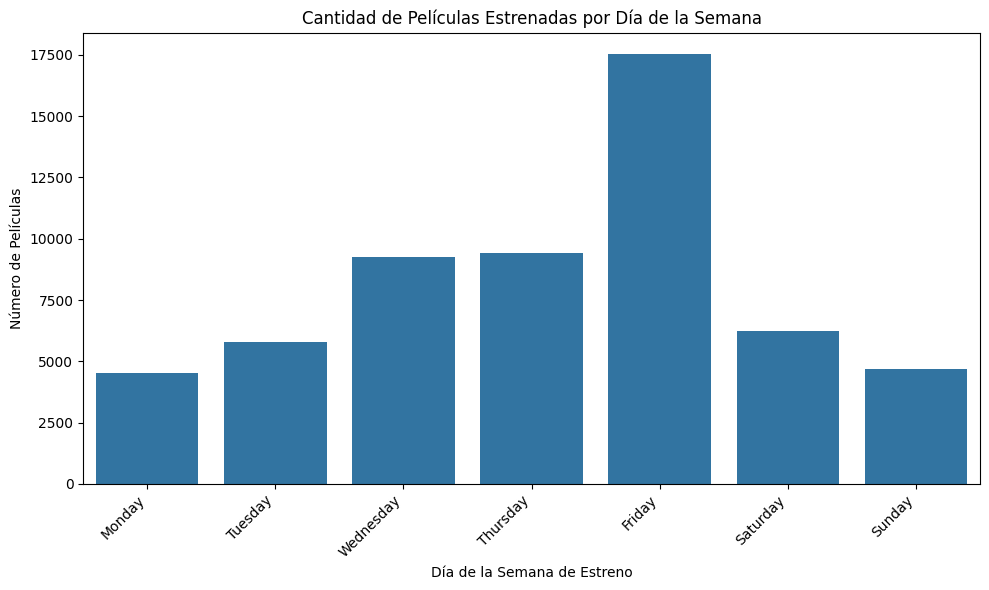

In [13]:
#eliminamos filas con fechas de lanzamiento nulas
df_released = df.dropna(subset=['release_date'])
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# 1. Cantidad de películas estrenadas por año
plt.figure(figsize=(12, 6))
df_released['release_year'] = df_released['release_date'].dt.year
sns.histplot(df_released['release_year'], bins=df_released['release_year'].nunique(), discrete=True)
plt.title('Cantidad de Películas Estrenadas por Año')
plt.xlabel('Año de Estreno')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Cantidad de películas estrenadas por mes
plt.figure(figsize=(10, 6))
df_released['release_month'] = df_released['release_date'].dt.month
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.countplot(data=df_released, x='release_month', order=range(1, 13))
plt.title('Cantidad de Películas Estrenadas por Mes')
plt.xlabel('Mes de Estreno')
plt.ylabel('Número de Películas')
plt.xticks(ticks=range(12), labels=month_order)
plt.tight_layout()
plt.show()

# 3. Cantidad de películas estrenadas por día de la semana
plt.figure(figsize=(10, 6))
df_released['release_dayofweek'] = df_released['release_date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df_released, x='release_dayofweek', order=day_order)
plt.title('Cantidad de Películas Estrenadas por Día de la Semana')
plt.xlabel('Día de la Semana de Estreno')
plt.ylabel('Número de Películas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
# Función para extraer la lista de nombres de géneros
def get_genre_list(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        if isinstance(genres_list, list):
            return [genre['name'] for genre in genres_list]
    except (ValueError, TypeError):
        return []

df['genres_list'] = df['genres'].apply(get_genre_list)

#creamos columnas binarias para cada género
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_binary = pd.DataFrame(mlb.fit_transform(df['genres_list']),
                                columns=mlb.classes_,
                                index=df.index)

#concatenamos las columnas binarias de géneros al DataFrame original
df = pd.concat([df, genres_binary], axis=1)

print("Columnas binarias de géneros creadas.")
print(df.head())

Columnas binarias de géneros creadas.
     budget                                             genres     id  \
0  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...    862   
1  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   8844   
2         1  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  15602   
3  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  31357   
4         1                     [{'id': 35, 'name': 'Comedy'}]  11862   

  original_language                                           overview  \
0                en  Led by Woody, Andy's toys live happily in his ...   
1                en  When siblings Judy and Peter discover an encha...   
2                en  A family wedding reignites the ancient feud be...   
3                en  Cheated on, mistreated and stepped on, the wom...   
4                en  Just when George Banks has recovered from his ...   

   popularity                               production_countries release_date 

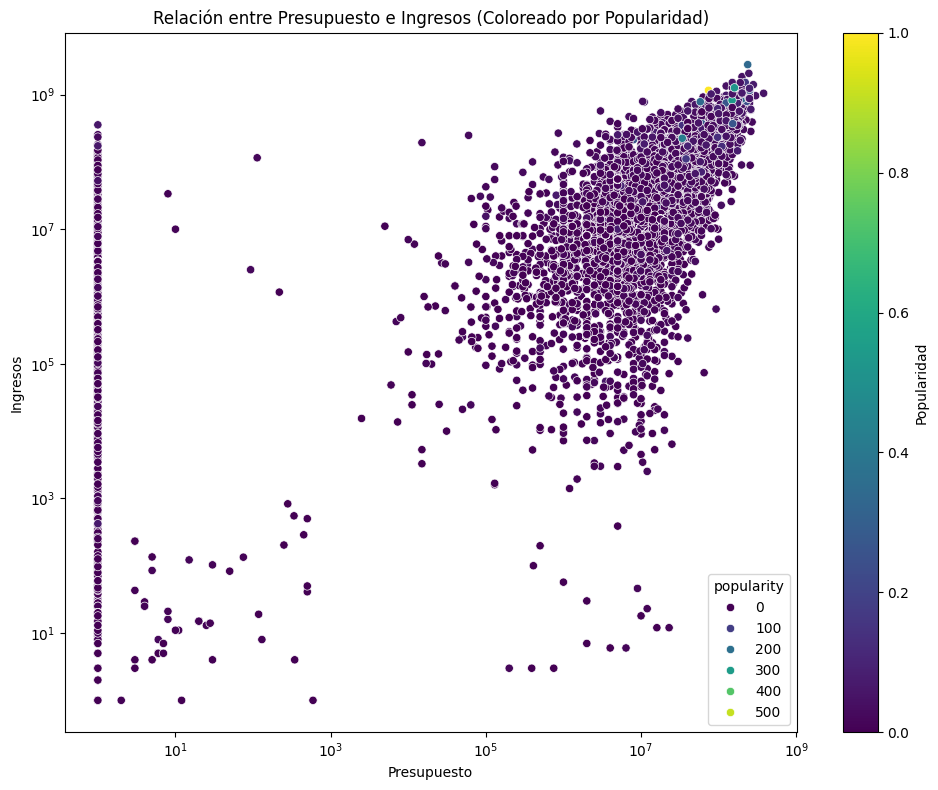

In [14]:
#Scatter Plot de Budget vs. Revenue coloreado por Popularidad
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(x='budget', y='revenue', hue='popularity', data=df, palette='viridis')
plt.title('Relación entre Presupuesto e Ingresos (Coloreado por Popularidad)')
plt.xlabel('Presupuesto')
plt.ylabel('Ingresos')

#obtenemos el objeto mapeable en el scatterplot
mappable = scatter_plot.collections[0] if scatter_plot.collections else None

plt.colorbar(mappable, label='Popularidad')
plt.xscale('log') 
plt.tight_layout()
plt.show()

Machine Learning

In [7]:
from collections import Counter
from itertools import combinations

In [21]:
#Recomienda películas similares basándose en la co-ocurrencia de géneros.
def recomendacion(titulo, df, top_n=5):
    try:
        #obtenemos la lista de géneros de la película de entrada
        genres_str = df[df['title'] == titulo]['genres'].iloc[0]
        input_genres = [g['name'] for g in ast.literal_eval(genres_str)]
    except (IndexError, ValueError, TypeError):
        return f"No se encontró la película '{titulo}' o el formato de géneros es incorrecto."

    #calculamos la similitud basada en la cantidad de géneros en común
    similarity_scores = []
    for index, row in df.iterrows():
        if row['title'] == titulo:
            continue

        try:
            other_genres_str = row['genres']
            other_genres = [g['name'] for g in ast.literal_eval(other_genres_str)]
            common_genres = len(set(input_genres) & set(other_genres))
            similarity_scores.append((row['title'], common_genres))
        except (ValueError, TypeError):
            continue

    #ordenamos las películas por la cantidad de géneros en común (descendente)
    similarity_scores.sort(key=lambda item: item[1], reverse=True)

    #devolvemos los nombres de las top_n películas más similares
    recommended_movies = [item[0] for item in similarity_scores[:top_n]]
    return recommended_movies

In [22]:
pelicula_a_recomendar = "Toy Story"
recomendaciones = recomendacion_simple(pelicula_a_recomendar, df)
print(f"Películas similares a '{pelicula_a_recomendar}' (basado en géneros): {recomendaciones}")

Películas similares a 'Toy Story' (basado en géneros): ['A Goofy Movie', 'Aladdin', 'The Aristocats', 'Space Jam', 'Oliver & Company']
